# Blurs & Filters

 ## Motivation
 
 When using a filter and your phone, it is mostly a combination of low level processing like blurs, contrast changes and colour changes. These processes are all filters. They take an image, process it and come up with some output. Here, we will simply blur an image. Before the implementation, we first have to understand three concepts: kernel convolution, decomposition into channels, gamma correction, mean blur and gaussian blur.

### Kernel Convolution

Kernel convolution is the core of a lot of things: gaussian blurs, mean blurs, edge detection, etc. It is a simple technique that is popular in computer vision work. The process consists of taking a small grid of numbers and apply an operation with it over the whole image. By using different numbers in this kernel, we can perform blurs, or edge detection or sharpen, unsharpen (basically a lot of differen effects).

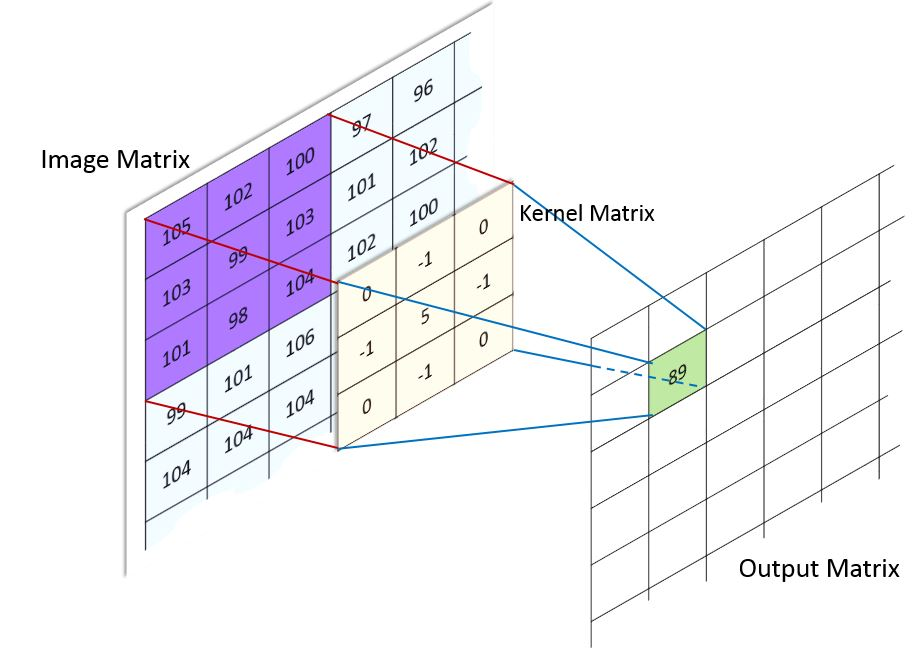

In [271]:
# Source: http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html
Image(r'images\kernel_schema.jpg', width=500, height=500)

In the previous example, we want to calculate the kernel convolution for the pixel 99. The computation here consists simply to multiply the pixels matrix (purple cells) by the kernel matrix (yellow cells). Then, we have to sum all the values, which is 89 in this case. We substitute this value into the output matrix. 

### Decomposition into Channels

Processes such as gamma correction and kernel convolution are defined on matrices with elements in the set of real numbers. This is the case of a black and white image. However, what should we do for colored images? Each pixel is represented as a vector in $\mathbb{R}^{3}$. The solution is simply to decomposed a colored image into each channel (RGB). By doing so, we have one matrix for each channel. Then, we can apply our transformations. Here is an example of channels decomposition:

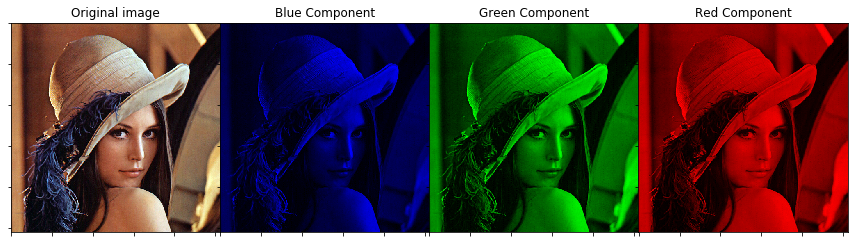

In [209]:
plot_rgb_channels(io.imread(r'images\lena_color.png'))

### Gamma Correction

To realize a realistic blur, we first convert pixel values to light values (with gamma correction), then blur, then convert back to pixel values. If we avoid this, dark smears over light in ways that it does not do in real life. 

Let's consider a pixel from a black and white picture. It can be represents as an integer value from $0$ (black) to $255$ (white). Before applying the gamma correction, we have to rescale the pixels so that they are between $0$ and $1$. Thus, we have to divide each pixel by $255$. The gamma function is the following:

$$
f(\gamma)=x^{\frac{1}{\gamma}}
$$

where $x\in\big\{0,\frac{1}{255},\frac{2}{255},...,\frac{254}{255},1\big\}$ is the value of the pixel and $\gamma>0$ is the hyperparameter that we use for the correction. We typically use the value of $\gamma = 2.2$.

### Mean Blur

For the sake of simplicity, let's consider the kernel matrices (format $3$x$3$) for mean blur ($\mathbf{M}_{blur}$) and gaussian blur ($\mathbf{G}_{blur}$). In our implementation, we normalized weights in the kernel matrix. In other words, we divide each element of the kernel matrix by the sum of the absolute value of each element in the kernel matrix. 

The kernel matrix (for mean blur) consists of giving the same weight for each element of the kernel matrix. 

$$
   \mathbf{M}_{blur}=
  \left[ {\begin{array}{cc}
   \frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
   \frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
   \frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
  \end{array} } \right]
$$

At first sight, this way of constructing a kernel matrix seems good. However, there is a small problem with it. This problem is described in the example section. This problem is also present in the gaussian kernel matrix.

### Gaussian Blur 

The kernel matrix (for gaussian blur) is based on the computations of two normal distribution with mean zero and variance one. We center each of these distributions with the row center and the column center. Then, we compute the outer product of those vectors and we normalize the matrix.

$$
\mathbf{v}^{\top} = (0.2419, 0.3989, 0.2419) \Rightarrow \mathbf{v}\mathbf{v}^{\top} =
  \left[ {\begin{array}{cc}
   0.0751 & 0.1238 & 0.0751 \\ 
   0.1238 & 0.2042 & 0.1238 \\ 
   0.0751 & 0.1238 & 0.0751 \\ 
  \end{array} } \right] = \mathbf{G}_{blur}
$$

Some people prefer to use integers to build the gaussian kernel. Thus, the following kernel is frequently used (we will not use it here):

$$
\mathbf{G}_{blur} =
  \left[ {\begin{array}{cc}
   1 & 2 & 1 \\ 
   2 & 4 & 2 \\ 
   1 & 2 & 1 \\ 
  \end{array} } \right] 
$$

## Implement Bluring from Scratch

In [272]:
def blur_pixel(pixel, kernel):
    """
    Multiply a pixel and its neighborhood by a kernel.
    pixel: A pixel and its neighbours.
    kernel: A kernel to average the pixel.
    """
    matrix_multi = np.multiply(pixel, kernel)
    return matrix_multi.sum()

In [273]:
def blur_channel_image(kernel_method, image, sigma, kernel_size):
    """
    Blur the channel of an image with the appropriate kernel.
    kernel_method: Method to generate the kernel matrix (mean or gaussian)
    image: Image to blur.
    sigma: Value of standard deviation (for gaussian kernel case)
    kernel_size: Number of rows (or columns for the kernel matrix)
    """
    particular_method = partial(kernel_method,sigma_value=sigma)
    
    # Envelop the image with zeroes
    corrected_image = zeroes_matrix_container(image,kernel_size)
    new_image = np.empty([corrected_image.shape[0], corrected_image.shape[1]])
    kernel = particular_method(kernel_size)
    
    nb_rows = corrected_image.shape[0]
    nb_columns = corrected_image.shape[1]
    nb_zeroes_line = int((kernel_size-1)/2)
    
    # Apply the filter transformation on every pixel of the original image
    for i in range(nb_zeroes_line,nb_rows-1-nb_zeroes_line):
        for j in range(nb_zeroes_line,nb_rows-1-nb_zeroes_line):
            new_image[i,j] = blur_pixel(corrected_image[(i-(nb_zeroes_line)):(i+(nb_zeroes_line)+1),(j-(nb_zeroes_line)):(j+(nb_zeroes_line)+1)], kernel)
            
    return new_image[(nb_zeroes_line):(nb_rows-1-nb_zeroes_line),(nb_zeroes_line):(nb_rows-1-nb_zeroes_line)]

In [274]:
def blur_image(gamma, kernel_method, image, sigma, kernel_size):
    """
    Blur an image with a given kernel method.
    gamma: Value of the gamma correction.
    kernel_method: Method to generate the kernel matrix (mean or gaussian)
    sigma: Value of standard deviation (for gaussian kernel case)
    image: Image to blur.
    kernel_size: Number of rows (or columns for the kernel matrix)
    """
    particular_method = partial(kernel_method)
    
    # Apply the gamma correction
    rgb = list(split_into_rgb_channels(nested_arrays))
    rgb_blured = []
    for image_channel in rgb:
        # Apply the gamma correction for the current channel and add it to a list
        gamma_corrected_channel = gamma_correction(image_channel,gamma)
        
        # Apply the kernel operation for every image pixel
        blured_channel = blur_channel_image(particular_method,gamma_corrected_channel,sigma,kernel_size)
        clean_blured_channel = gamma_correction(blured_channel,1/gamma)
        
        # Add the blured channel to the blured channel list
        rgb_blured.append(clean_blured_channel)
    
    return bind_rgb_channels(*rgb_blured)

In [275]:
def zeroes_matrix_container(image,kernel_size):
    """
    Create a sparse matrix (only zeroes) that will contains the image.
    image: Image to envelop of zeroes.
    kernel_size: Number of rows (or columns) in the kernel. 
    Source: sangrey (https://stackoverflow.com/questions/40833073/insert-matrix-into-the-center-of-another-matrix-in-python)
    """
    
    image_nb_rows = image.shape[0]
    image_nb_columns = image.shape[1]
    
    zeroes_matrix = np.zeros((image_nb_rows+kernel_size-1,image_nb_columns+kernel_size-1))
    
    n_zeroes_lines = zeroes_matrix.shape[0]
    n_image_lines = image.shape[0]
    lower = (n_zeroes_lines) // 2 - (n_image_lines // 2)
    upper = (n_zeroes_lines // 2) + (n_image_lines // 2) + 1 if image_nb_rows%2!=0 else (n_zeroes_lines // 2) + (n_image_lines // 2) 
    
    n_zeroes_columns = zeroes_matrix.shape[1]
    n_image_columns = image.shape[1]
    left = (n_zeroes_columns) // 2 - (n_image_columns // 2)
    right =  (n_zeroes_columns // 2) + (n_image_columns // 2) + 1 if image_nb_columns%2!=0 else (n_zeroes_columns // 2) + (n_image_columns // 2)
    
    zeroes_matrix[lower:upper, left:right] = image
    return zeroes_matrix

In [290]:
def mean_blur_kernel(kernel_size,sigma_value=1):
    """
    Create a matrix kernel for the bluring effect.
    kernel_size: number of rows (and columns) of the kernel.
    """
    return np.ones((kernel_size, kernel_size))/(kernel_size*kernel_size)

In [277]:
def gaussian_blur_kernel(kernel_size,sigma_value):
    """
    Create a matrix kernel for the bluring effect.
    kernel_size: number of rows (and columns) of the kernel.
    sigma_value: Standard deviation of the normal pdf.
    """
    values = np.array([normal_pdf(i,sigma=sigma_value) for i in range(-int((kernel_size-1)/2),int((kernel_size-1)/2)+1)])
    weights = np.outer(values, values)
    normalize_weights = weights/weights.sum()
    return normalize_weights

In [278]:
def bind_rgb_channels(red, green, blue):
    """
     Takes the different color channels and create an image.
     red: Red color channel.
     green: Green color channel.
     blue: Blue color channel.
    """
    img = np.zeros((red.shape[0], red.shape[1], 3), dtype = red.dtype)
    for values, color, channel in zip((red, green, blue), ('red', 'green', 'blue'), (2,1,0)): 
        img[:,:,channel] = values
    return img

In [279]:
def split_into_rgb_channels(image):
    """
    Split the target image into its red, green and blue channels.
    image: A numpy array of shape (rows, columns, 3).
    output: Three numpy arrays of shape (rows, columns) and dtype same as
           image, containing the corresponding channels. 
    Source: https://knowpapa.com/opencv-rgb-split/ 
    """
    red = image[:,:,2]
    green = image[:,:,1]
    blue = image[:,:,0] 
    return red, green, blue

In [280]:
def gamma_correction(nested_arrays, gamma):
    """
    Apply gamma correction on a given matrix.
    nested_arrays: Matrix of one of the color channel of the image.
    gamma: Gamma value.
    """
    # Rescale so that pixels are in interval [0,1]
    nested_arrays_normalized = np.divide(nested_arrays,255) 
    
    # Application of the gamma transformation
    nested_arrays_transformed = np.power(nested_arrays_normalized,1/gamma)
    
    # Normalization of the pixels (to be in {0,1,2,...,255})
    nested_arrays_corrected = np.divide(nested_arrays_transformed,nested_arrays_transformed.max())
    
    # Rescale our image and correct the datatype to int
    nested_arrays_rescaled = np.multiply(nested_arrays_corrected,255)
    nested_arrays_gamma = np.floor(nested_arrays_rescaled)
    return nested_arrays_gamma.astype(int)

In [281]:
def normal_pdf(x, mu=0, sigma=1):
    """
    Normal probability density function.
    mu: Average of the normal pdf (by default 0).
    sigma: Standard deviation of the normal pdf (by default 1).
    """
    sqrt_two_pi = math.sqrt(2 * math.pi)
    return (math.exp(-(x-mu) ** 2 / 2 / sigma ** 2) / (sqrt_two_pi * sigma))

In [282]:
def plot_rgb_channels(image):
    """
    Plot the different color channels (RGB). 
    image: Image to decompose in different channels.
    """
    red, green, blue = split_into_rgb_channels(image) 
    
    channels = []
    for values, color, channel in zip((red, green, blue), ('red', 'green', 'blue'), (2,1,0)):
        img = np.zeros((values.shape[0], values.shape[1], 3), dtype = values.dtype) 
        img[:,:,channel] = values
        channels.append(img)
    
    
    fig, axs = plt.subplots(1, 4,figsize=(15,15))
    fig.subplots_adjust(wspace=0, hspace=0)
    axs[0].imshow(image)
    axs[0].set_title('Original image')
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])

    axs[1].imshow(channels[0])
    axs[1].set_title('Blue Component')
    axs[1].set_xticklabels([])
    axs[1].set_yticklabels([])
    
    axs[2].imshow(channels[1])
    axs[2].set_title('Green Component')
    axs[2].set_xticklabels([])
    axs[2].set_yticklabels([])
    
    axs[3].imshow(channels[2])
    axs[3].set_title('Red Component')
    axs[3].set_xticklabels([])
    axs[3].set_yticklabels([])

In [283]:
def plot_sensibility_variance(image,gamma,kernel_size):
    """
    Plot a set of images for variance sensitivity analysis.
    image: Image to decompose in different channels.
    gamma: Value of gamma for the gamma correction.
    kernel_size: Size of the kernel matrix.
    """
    sigma_5 = blur_image(gamma, gaussian_blur_kernel, image, 1, kernel_size)
    sigma_10 = blur_image(gamma, gaussian_blur_kernel, image, 3, kernel_size)
    sigma_15 = blur_image(gamma, gaussian_blur_kernel, image, 7, kernel_size)
    mean_blured = blur_image(gamma, mean_blur_kernel, image, 5, kernel_size)
    
    
    fig, axs = plt.subplots(1, 4,figsize=(15,15))
    fig.subplots_adjust(wspace=0, hspace=0)
    axs[0].imshow(sigma_5)
    axs[0].set_title('$\mathcal{N}(0,1)$')
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])

    axs[1].imshow(sigma_10)
    axs[1].set_title('$\mathcal{N}(0,9)$')
    axs[1].set_xticklabels([])
    axs[1].set_yticklabels([])
    
    axs[2].imshow(sigma_15)
    axs[2].set_title('$\mathcal{N}(0,49)$')
    axs[2].set_xticklabels([])
    axs[2].set_yticklabels([])
    
    axs[3].imshow(mean_blured)
    axs[3].set_title('Mean Blur')
    axs[3].set_xticklabels([])
    axs[3].set_yticklabels([])

In [284]:
def plot_sensibility_kernel_size(image,gamma):
    """
    Plot a set of images for kernel size sensitivity analysis.
    image: Image to decompose in different channels.
    gamma: Value of gamma for the gamma correction.
    """
    mean_blured_11 = blur_image(gamma, mean_blur_kernel, image, 5, 11)
    mean_blured_25 = blur_image(gamma, mean_blur_kernel, image, 5, 25)
    mean_blured_33 = blur_image(gamma, mean_blur_kernel, image, 5, 33)
    mean_blured_45 = blur_image(gamma, mean_blur_kernel, image, 5, 45)
    
    
    fig, axs = plt.subplots(1, 4,figsize=(15,15))
    fig.subplots_adjust(wspace=0, hspace=0)
    axs[0].imshow(mean_blured_11)
    axs[0].set_title('kernel_size$=11$')
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])

    axs[1].imshow(mean_blured_25)
    axs[1].set_title('kernel_size$=25$')
    axs[1].set_xticklabels([])
    axs[1].set_yticklabels([])
    
    axs[2].imshow(mean_blured_33)
    axs[2].set_title('kernel_size$=33$')
    axs[2].set_xticklabels([])
    axs[2].set_yticklabels([])
    
    axs[3].imshow(mean_blured_45)
    axs[3].set_title('kernel_size$=45$')
    axs[3].set_xticklabels([])
    axs[3].set_yticklabels([])

## Example

Lets work on a simple example to explore our different bluring techniques.

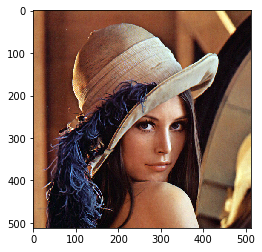

In [285]:
# Import packages
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
from functools import partial
import math
from IPython.display import Image

# Import the image to resize
nested_arrays = io.imread(r'images\lena_color.png')
imgplot = plt.imshow(nested_arrays)

 ### Mean Blur Sensitivity Analysis (Kernel Size)
 
 If we try to apply the kernel convolution on pixel close (the term close depends on the kernel size) and on the edges of the image, we will have to multiply the kernel by pixels that are not defined! To solve this problem, we simply put enough zeroes around our image. However, a bad consequence is that our mean values close and on the edges of the new image are now biased. Because these means use zeroes for their computations, the edges of our image will be darker (because $0$ for every channel corresponds to black). Thus, as the kernel size increases, the new image should be more blured and should have thicker black lines on the edges. A better approach for the preceding problem would be to adjust the kernel weights for pixel close to the edges.

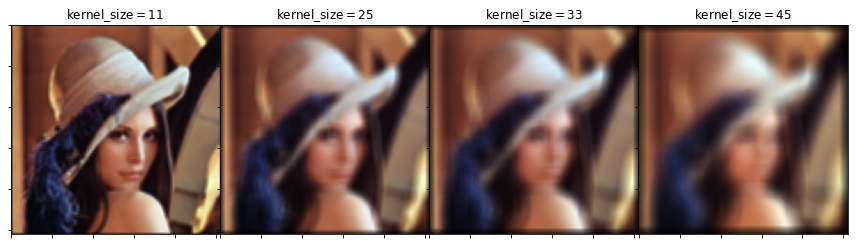

In [291]:
plot_sensibility_kernel_size(nested_arrays,2.2)

### Gaussian Blur Sensitivity Analysis (Variance)

One can notice that the gaussian kernel matrix depends on the variance of our normal probability distribution function (with mean equals to zero). As the variance increases, the normal distribution becomes flatter. Thus, the weights of the gaussian kernel matrix become very close to each other. In other words, for a fixed kernel size, the gaussian kernel matrix becomes closer to the mean kernel matrix as the variance of the normal density function increases. Also, we still have the black lines edges problem (see mean blur sensitivity analysis for more details).

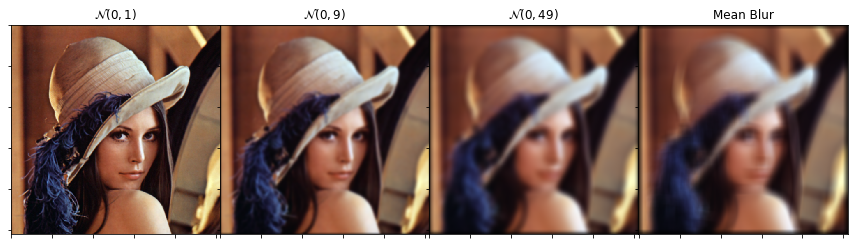

In [287]:
plot_sensibility_variance(nested_arrays,2.2,25)